In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy.modeling.physical_models import BlackBody as BB

# Read TepCat

This step is needed to have a database of transiting GP to read parameters from

In [2]:
from astropy.io import ascii

ColumnNames = ascii.read('tepcat-allplanets-csv.csv', data_start=0, data_end=1, )[0]
TepCat = ascii.read('tepcat-allplanets-csv.csv', data_start=1)
for column_name, TC_col in zip(ColumnNames, TepCat.colnames):
    if 'err' in column_name: 
        TepCat.remove_column(TC_col)
    else:
        TepCat[TC_col].name = column_name
del ColumnNames
TepCat.add_index('System')

# Model
1. Select a favourable target such as WASP-121b or similar
2. We will need the orbital period in seconds. So I convert period from days to seconds
3. Calculate a simple estimate of the eclipse depth, and use this as the peak-to-peak amplitude of the phase curve signal model.
4. The measured signal vs time is proportional to $F_s + F_p$, normalised to $F_s$, i.e. $1 + F_p/F_s$. In what follows, model is $F_p/F_s$
5. I also add a phase shift, that can be randomised in a further iteration of this work. 

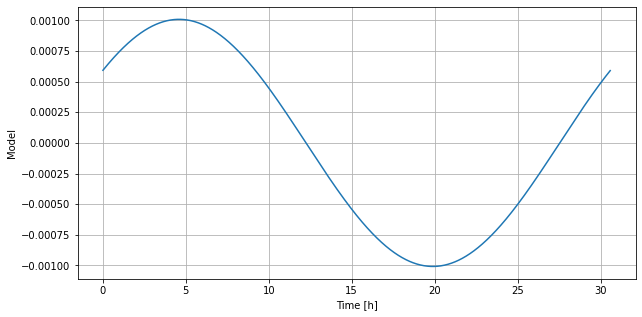

In [3]:
Name = 'WASP-121'
phase = 0.2*np.pi

system = TepCat.loc[Name]
system['Period'] *= u.day.to(u.s)
PlanetSED = BB(temperature=system['Teq']*u.K, scale = 1*u.W/u.m**2/u.sr/u.micron)
StarSED   = BB(temperature=system['Teff']*u.K, scale = 1*u.W/u.m**2/u.sr/u.micron)

eclipse_depth = (system['R_b']*u.Rjup.to(u.m)/(system['R_A']*u.Rsun.to(u.m)))**2 * \
            PlanetSED(2.2*u.micron)/StarSED(2.2*u.micron)
eclipse_depth = eclipse_depth.value

delta_t = 60.0 # seconds->days
tt = np.arange(0, system['Period'], delta_t)

model  = 0.5*eclipse_depth*np.sin(2*np.pi*tt/system['Period'] + phase) 

fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.plot(tt/3600, model)
ax.set_ylabel('Model')
ax.set_xlabel('Time [h]')
ax.grid()


# Baseline simulation

Here I want to lay down the simulation procedure on a simple case. That is
1. Run "Nsim" simulations
2. Each simulation is an observation, corresponding to a timeline constructed from adding white noise to the true value of the signal (the model). 
3. I use a noise drawn from a Gaussian distribution with zero mean, and a $\sigma = 0.1$%, that can be replaced with an ExoRad estimate. 
4. I then leas-square fit each of the Nsim simulation using a linear model:
$$ model = a \sin(2\pi t/P) + a\sin(2\pi t/P) + b \sin(2\pi t/P) + c$$
where $a$, $b$, and $c$ are the model parameters
5. The ensamble distribution of the amplitude and phase are
$$ A = \sqrt{a^2 + b^2}$$
$$ \phi = \arctan(a/b)$$
6. I can then calculate the statistics:
    - $\bar A = {\rm average}(A)$
    - $\sigma = {\rm stdev}(A)$
    - SNR = ${\bar A}/\sigma$
    
   and similar for the phase.
7. I can also see if there is a statistically significant bias (significant here means given the precision of the simulation
$$ {\rm bias} = \frac{ {\rm EclipseDepth}/2 - {\bar A}}{ {\rm EclipseDepth}/2} $$
to be compared with the significance of this bias estimate, i.e.
$$ {\rm Error}(\rm bias) = \frac{ {\rm Error}(\bar A)}{{\rm EclipseDepth}/2} = \frac{ \sigma/\sqrt{Nsim}}{{\rm EclipseDepth}/2}$$

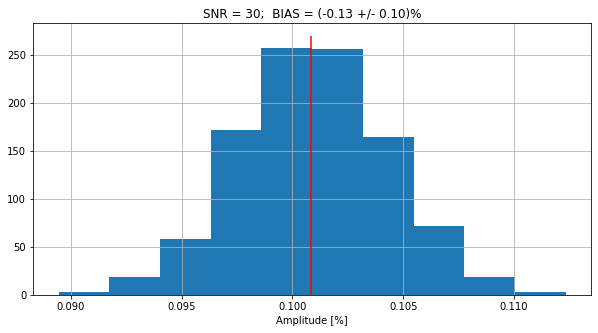

In [4]:
Nsim = 1024     # this many simulations
noise_std =1e-3 # this value to be replaced with ExoRad's estimate

# Repeat Nsim independent observations adding noise to each
# Observations are stored in D1's first dimension
D1  = np.zeros( (Nsim, tt.size) ) + model
D1 += np.random.randn( *D1.shape )*noise_std

# Least-square fit the data
A = np.c_[np.sin(2*np.pi*tt/system['Period']), 
          np.cos(2*np.pi*tt/system['Period']), 
          np.ones(tt.size)]

par, *_ = np.linalg.lstsq(A, D1.T, rcond=-1)

# Calculate statistics
amplitude = np.sqrt( par[0]**2 + par[1]**2)
amplitude_mean = amplitude.mean()
amplitude_std  = amplitude.std()
amplitude_snr  = amplitude_mean/amplitude_std
amplitude_bias = (0.5*eclipse_depth - amplitude_mean)/(0.5*eclipse_depth)
amplitude_bias_error = amplitude_std/(0.5*eclipse_depth)/np.sqrt(amplitude.size)
TITLE = 'SNR = {:.0f};  BIAS = ({:.2f} +/- {:.2f})%'.format(amplitude_snr, 
                                           100*amplitude_bias,
                                           100*amplitude_bias_error)

fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.hist(100*amplitude)
ax.set_xlabel('Amplitude [%]')
ax.set_title(TITLE)
ax.vlines(0.5*eclipse_depth*100, *ax.get_ylim(), color='r')
ax.grid()

# Temperature-dependent trend

We want to model a temperature-dependent trend. Best proxy I have so far is the temperature of M1 and M2 of the BlastPol telescope during its Antarctic flight in 2013.

I use the mean of these two, in units of Centigrades

BlastPol housekeepings were sampled at 5Hz. Our simulation runs with a cadence of 60 s. 

Therefore I average the BlastPol HK 60s by 60s. This is technically achieved using a technique called filter-and-decimate, that works as follow
1. Box-car filter the data (sometimes called moving-average), with a kernel that 60 s long. 
2. Take one sample every 60 s.

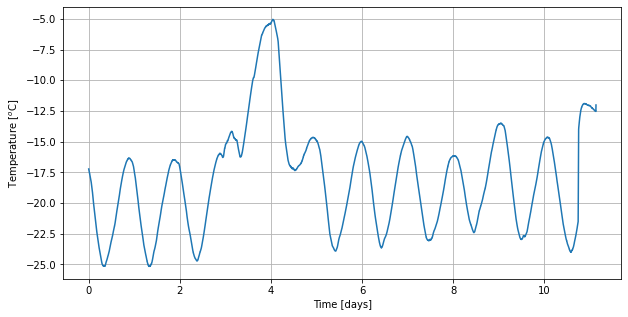

In [5]:
# M1 temperature
TM1 = np.fromfile('t_prime_sf', dtype=np.uint16)
TM1 = 2.840909090909e-02*TM1 -2.731500000000e+02
# M2 temperature
TM2 = np.fromfile('t_second_sf', dtype=np.uint16)
TM2 = 2.840909090909e-02*TM2 -2.731500000000e+02

TM = 0.5*(TM1+TM2)
blast_time = np.arange(TM.size)/5.0

# Cut away firs two days worth of data as it contains glitches
TM = TM[864000:]
blast_time = blast_time[864000:]

# regrid blast data on the simulation time grid by
#  1. box car avaraging with kernel delta_t long
#  2. decimating at a delta_t cadence
#  note: now data have delta_t cadence
kernel = np.ones( np.int(delta_t*5) )
TM = np.convolve(TM, kernel/kernel.size, mode='same')[kernel.size::kernel.size]

fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.plot(np.arange(TM.size)*60/3600/25, TM)
ax.set_ylabel ( 'Temperature [$^o$C]')
ax.set_xlabel('Time [days]')
ax.grid()
_=_


# Data trend

Here I add a temperature correlated trend to the data using the following prescription

1. Select a temperature timeline of length = the time of the observation. This timeline is selected with a random starting time in the BlastPol temperature HK
2. Scale the trend peak-to-peak to some value. Below I use 0.1%, but different values should be investigated. 
3. Add the trend to the data as a multiplicative noise term. The idea being that such trend can change the instrument throughput because of thermoelastic effects. 
4. The trend is added as 
$$ [1+g(t)] \times (F_s + F_p)/F_s \simeq 1 + g(t) + F_p/F_s$$
So the signal we are studying has the form of 
$$ g(t) + F_p/F_s$$

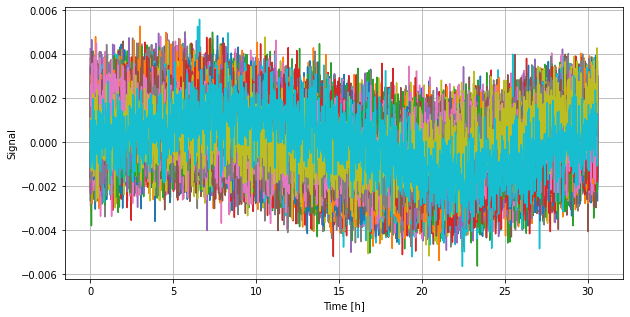

In [6]:
Nsim = 1024     # this many simulations
noise_std =1e-3 # this value to be replaced with ExoRad's estimate
trend_amplitude = 0.001

# Repeat Nsim independent observations adding noise to each
# Observations are stored in D1's first dimension
D1  = np.zeros( (Nsim, tt.size) ) + model
D1 += np.random.randn( *D1.shape )*noise_std
TData = np.zeros_like(D1)

for k in range(D1.shape[0]):
    idx0 = np.random.randint(0, high=TM.size  - D1.shape[1])
    temp_trend = TM[idx0:idx0+D1.shape[1]].copy()
    TData[k] = temp_trend.copy()
    temp_trend -= temp_trend.mean()
    temp_trend /= np.abs(temp_trend).max()
    temp_trend = trend_amplitude*temp_trend
    D1[k] += temp_trend

fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.set_ylabel ( 'Signal')
ax.set_xlabel('Time [h]')
ax.grid()

for k in range(100):
    ax.plot(tt/3600, D1[k])

Next, we need to see if we can recover the science signal.

First, I make the hypothesis that the Earth-synchronous signal is orthogonal to the exoplanet signal. That means, I repeat the same lstsq fit done previously and see what happen...

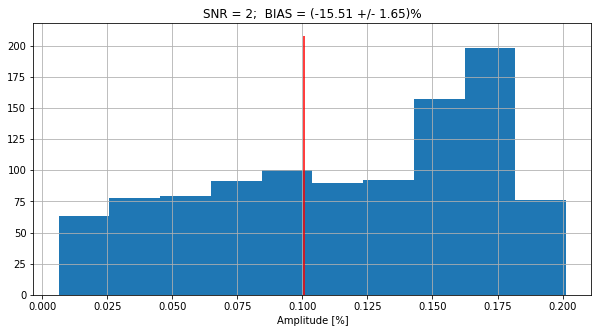

In [7]:
# Least-square fit the data
A = np.c_[np.sin(2*np.pi*tt/system['Period']), 
          np.cos(2*np.pi*tt/system['Period']), 
          np.ones(tt.size)]

par, *_ = np.linalg.lstsq(A, D1.T, rcond=-1)

# Calculate statistics
amplitude = np.sqrt( par[0]**2 + par[1]**2)
amplitude_mean = amplitude.mean()
amplitude_std  = amplitude.std()
amplitude_snr  = amplitude_mean/amplitude_std
amplitude_bias = (0.5*eclipse_depth - amplitude_mean)/(0.5*eclipse_depth)
amplitude_bias_error = amplitude_std/(0.5*eclipse_depth)/np.sqrt(amplitude.size)
TITLE = 'SNR = {:.0f};  BIAS = ({:.2f} +/- {:.2f})%'.format(amplitude_snr, 
                                           100*amplitude_bias,
                                           100*amplitude_bias_error)

fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.hist(100*amplitude)
ax.set_xlabel('Amplitude [%]')
ax.set_title(TITLE)
ax.vlines(0.5*eclipse_depth*100, *ax.get_ylim(), color='r')
ax.grid()

This clearly failed. All signals are Nyquist sampled, but we have a large aliasing noise. Perhaps there are ways to deal with that, but I don't know any off-the-top of my head.

Awaiting some clever idea, I can then try to fit an Earth-synchronous armonic signal...

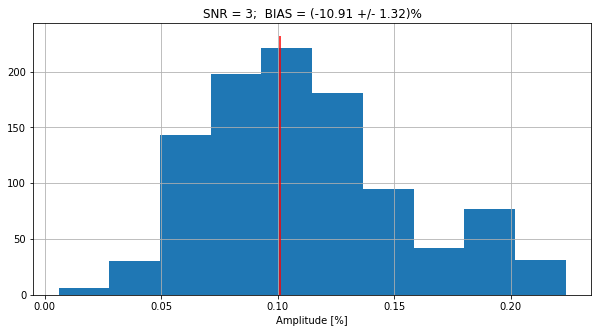

In [12]:
A = np.c_[np.sin(2*np.pi*tt/system['Period']), 
          np.cos(2*np.pi*tt/system['Period']), 
          np.sin(2*np.pi*tt/(24*3600)), 
          np.cos(2*np.pi*tt/(24*3600)), 
          np.ones(tt.size)]

par, *_ = np.linalg.lstsq(A, D1.T, rcond=-1)

# Calculate statistics
amplitude = np.sqrt( par[0]**2 + par[1]**2)
amplitude_mean = amplitude.mean()
amplitude_std  = amplitude.std()
amplitude_snr  = amplitude_mean/amplitude_std
amplitude_bias = (0.5*eclipse_depth - amplitude_mean)/(0.5*eclipse_depth)
amplitude_bias_error = amplitude_std/(0.5*eclipse_depth)/np.sqrt(amplitude.size)

TITLE = 'SNR = {:.0f};  BIAS = ({:.2f} +/- {:.2f})%'.format(amplitude_snr, 
                                           100*amplitude_bias,
                                           100*amplitude_bias_error)

fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.hist(100*amplitude)
ax.set_xlabel('Amplitude [%]')
ax.set_title(TITLE)
ax.vlines(0.5*eclipse_depth*100, *ax.get_ylim(), color='r')
ax.grid()

This also hasn't worked. Partially because the same aliasing argument of the previous attempt, but perhaps also because the armonic model is not a good one. 

I can then try to cross-correlate directly with the HK data. Noting, however, that there could be a transfer function between the HK and the effect. This transfer function is unknown at the curent time, but we can say that it is some sort of low-pass filter with some time delay. Not considering it here, implies a significatly, and unrealistic cased. 

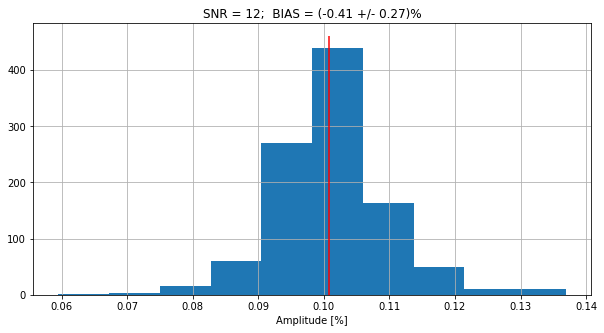

In [13]:
amplitude = np.zeros(D1.shape[0])

for k in range(D1.shape[0]):

    A = np.c_[np.sin(2*np.pi*tt/system['Period']), 
              np.cos(2*np.pi*tt/system['Period']), 
              TData[k],
              np.ones(tt.size)]

    par, *_ = np.linalg.lstsq(A, D1[k], rcond=-1)
    amplitude[k] = np.sqrt( par[0]**2 + par[1]**2)

# Calculate statistics
amplitude_mean = amplitude.mean()
amplitude_std  = amplitude.std()
amplitude_snr  = amplitude_mean/amplitude_std
amplitude_bias = (0.5*eclipse_depth - amplitude_mean)/(0.5*eclipse_depth)
amplitude_bias_error = amplitude_std/(0.5*eclipse_depth)/np.sqrt(amplitude.size)
TITLE = 'SNR = {:.0f};  BIAS = ({:.2f} +/- {:.2f})%'.format(amplitude_snr, 
                                           100*amplitude_bias,
                                           100*amplitude_bias_error)

fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.hist(100*amplitude)
ax.set_xlabel('Amplitude [%]')
ax.set_title(TITLE)
ax.vlines(0.5*eclipse_depth*100, *ax.get_ylim(), color='r')
ax.grid()

This is better, but far from ideal. The SNR more than a factor two worse. The bias, however, is not that bad.